# Import modules

In [51]:
import pickle
import numpy as np
from skimage import io
import os


from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from time import time

import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.datasets import ImageFolder
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

In [35]:
sns.set_style("dark")

# Is cuda available

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('❌CUDA is not available.  Training on CPU ...')
else:
    print('✔️CUDA is available!  Training on GPU ...')

✔️CUDA is available!  Training on GPU ...


# Define constants 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
# !unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip -d /content/gdrive/MyDrive/simpsons
!unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip

In [6]:
os.listdir()

['.config',
 'characters_illustration.png',
 'testset',
 'gdrive',
 'train',
 'sample_submission.csv',
 'sample_data']

In [7]:
# Разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']

# Все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# Работаем на видеокарте
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Директории изображений
MAIN_DIR = Path()
# MAIN_DIR = Path("/content/gdrive/MyDrive/simpsons")
TRAIN_DIR = MAIN_DIR / "train/simpsons_dataset"
TEST_DIR = MAIN_DIR / "testset"


In [8]:
!ls {MAIN_DIR}

characters_illustration.png  sample_data	    testset
gdrive			     sample_submission.csv  train


In [9]:
CLASSES_NAMES = sorted(os.listdir(TRAIN_DIR))
CLASSES_IDXS = np.arange(0, len(CLASSES_NAMES))
N_CLASSES = len(CLASSES_IDXS)
print(N_CLASSES, CLASSES_NAMES)
print(CLASSES_IDXS)

42 ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


$out = \frac{in - \mu}{\sigma} $

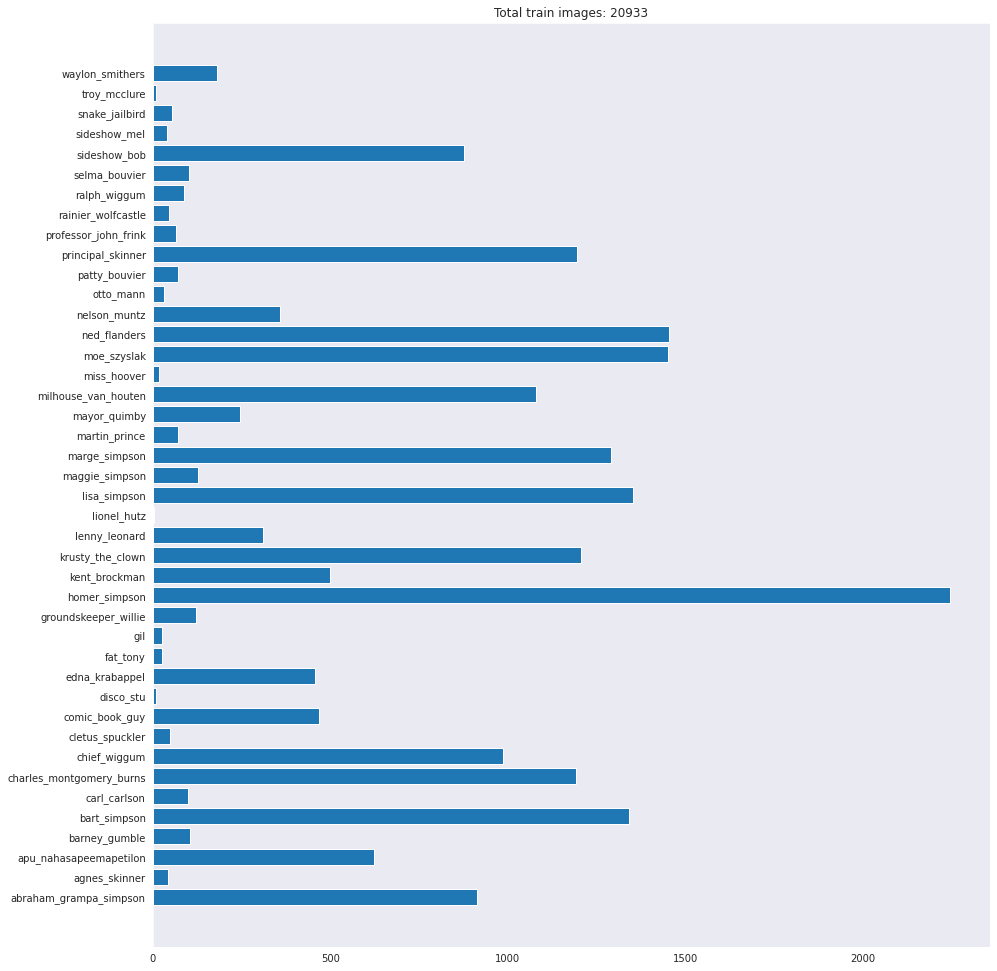

In [10]:
counter = []

for target in CLASSES_NAMES:
    imgs = os.listdir(TRAIN_DIR / target)
    counter.append(len(imgs))

TOTAL_IMAGES = sum(counter)
plt.figure(figsize=(15, 17))
plt.title(f"Total train images: {TOTAL_IMAGES}")
plt.barh(CLASSES_NAMES, counter)
plt.show()

# Calculate mean and std

In [11]:
def get_mean_and_std(batch_size):
    training_transforms = transforms.Compose([
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
        transforms.ToTensor()
        ])
    dataset = ImageFolder(root=TRAIN_DIR, transform=training_transforms)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in tqdm(loader):
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count

    return mean, std


# mean, std = get_mean_and_std(512)
# mean, std
# (tensor([0.4623, 0.4075, 0.3524]), tensor([0.2125, 0.1913, 0.2212]))

# Create DataLoader

train -> val -> test

In [12]:
class SimpsonsDataSet():
    def __init__(self, *, train_dir, test_dir, valid_size=0.25, total_images=20933):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.valid_size = valid_size
        self.total_images = total_images

        self.mean = torch.Tensor([0.485, 0.456, 0.406])
        self.std = torch.Tensor([0.229, 0.224, 0.225])

        self.train_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
            ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
            ])

        self.train_dataset = ImageFolder(root=self.train_dir,
                                         transform=self.train_transform)
        self.test_dataset = ImageFolder(root=self.test_dir,
                                         transform=self.test_transform)

    def get_train_val_loader(self, batch_size, use_sampler=False):

        valid_images = int(self.valid_size * self.total_images)
        print(valid_images)

        train_subset = Subset(self.train_dataset, range(valid_images, self.total_images))
        valid_subset = Subset(self.train_dataset, range(valid_images))
        
        if use_sampler:
            sampler = self._get_sampler()
            train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
        else:
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

        valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=True)
        return train_loader, valid_loader

    def get_test_loader(self, batch_size):
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        return test_loader
    
    def _get_sampler(self):
        class_weights = []
        for root, subdir, files in os.walk(self.train_dir):
            if len(files) > 0:
                class_weights.append(1 / len(files))

        sample_weights = [0] * len(self.train_dataset)
        for idx, (_, label) in tqdm(enumerate(self.train_dataset)):
            class_weight = class_weights[label]
            sample_weights[idx] = class_weight

        sampler = WeightedRandomSampler(sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)
        return sampler

    def show_train_images(self):
        loader = self.get_test_loader(9)
        for x, y in loader:
            grid = make_grid(x, nrow=3)
            print(f"labels: {y}")
            plt.figure(figsize=(11, 11))
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            break


In [13]:
BATCH_SIZE = 2

datasets = SimpsonsDataSet(train_dir=TRAIN_DIR, test_dir=TEST_DIR)
train_loader, val_loader = datasets.get_train_val_loader(BATCH_SIZE)
test_loader = datasets.get_test_loader(BATCH_SIZE)

5233


charles_montgomery_burns 6


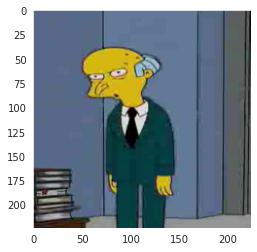

In [14]:
for X, y in val_loader:
    target = y[0]
    class_name = CLASSES_NAMES[target]
    class_index = CLASSES_IDXS[target]
    print(class_name, class_index)
    data = np.transpose(X[0], (1, 2, 0)) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    plt.imshow(data)
    break

edna_krabappel 11


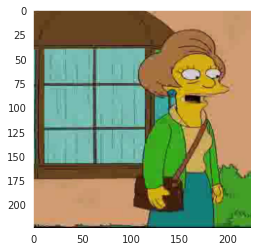

In [15]:
for X, y in train_loader:
    target = y[0]
    class_name = CLASSES_NAMES[target]
    class_index = CLASSES_IDXS[target]
    print(class_name, class_index)
    data = np.transpose(X[0], (1, 2, 0)) * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    plt.imshow(data)
    break

In [16]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [55]:
class FitModel():
    def __init__(self, model, batch_size=32):
        self.model = model.to(DEVICE)
        self.batch_size = batch_size
        datasets = SimpsonsDataSet(train_dir=TRAIN_DIR, test_dir=TEST_DIR)

        self.train_loader, self.val_loader = datasets.get_train_val_loader(batch_size)
        self.test_loader = datasets.get_test_loader(batch_size)
        
        self.total_images = 20933
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters())

        self.history = {"train_loss": [],
                        "valid_loss": [],
                        "test_loss": [],
                        "train_acc": [], 
                        "valid_acc": [],
                        "test_acc": []}
        self.write_loss = 10
    
    def train(self, epochs=5):
        start_time = time()
        self.model.train()
        for epoch in (range(epochs)):
            loss_sum = 0
            for batch_number, (X, y) in enumerate(self.train_loader, start=1):
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                self.optimizer.zero_grad()

                output = self.model(X)
                loss = self.criterion(output, y)
                loss.backward()
                self.optimizer.step()

                loss_sum += loss.item()
                # print(batch_number, batch_number % self.write_loss)
                if batch_number % self.write_loss == 0:
                    average_loss = loss_sum / self.write_loss
                    self.history["train_loss"].append(average_loss)
                    print(f"\rEpoch: {epoch + 1} Loss: {average_loss:.2f} Status: {100 * batch_number * self.batch_size / self.total_images:.1f}% Time:{time() - start_time:.2f}s", end="")
                    loss_sum = 0
            print(f"\rEpoch: {epoch + 1}\tLoss: {average_loss:.2f}\t100.0%", end="")
            print()
    
    def valid(self):
        with torch.no_grad():
            self.model.eval()
            for X, y in tqdm(self.val_loader):
                X = X.to(DEVICE)
                y = y.to(DEVICE)
                output = model(X)
                loss = self.criterion(output, y)
                self.history["valid_loss"].append(loss.item())


BATCH_SIZE = 64

model = SimpleCnn(N_CLASSES)
cnn_model = FitModel(model, BATCH_SIZE)

5233


In [56]:
cnn_model.train(epochs=1)

Epoch: 1	Loss: 1.80	100.0%


In [57]:
cnn_model.valid()

100%|██████████| 82/82 [00:26<00:00,  3.05it/s]


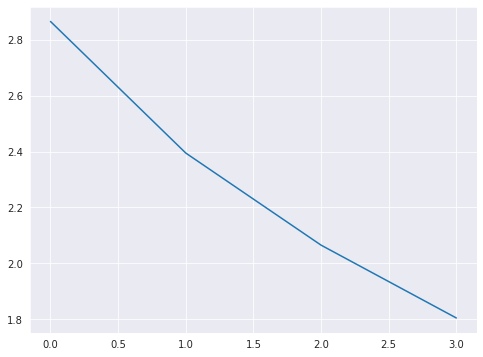

In [58]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
plt.plot(cnn_model.history["train_loss"]);

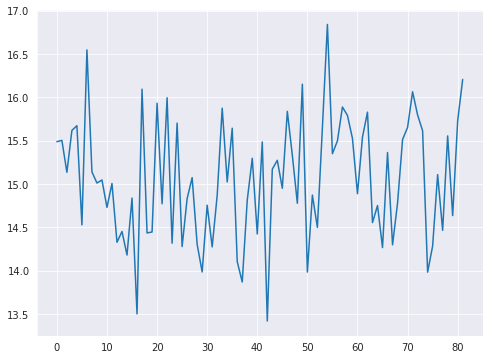

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(cnn_model.history["valid_loss"]);